In [143]:
#Nomes: GABRIELA SAFIRA NEVES DE OLIVEIRA e  THIAGO MARCEL MESSIAS DE ANDRADE

from skimage.io import imread
from matplotlib import pyplot as plt
from skimage.transform import hough_circle_peaks, hough_circle, hough_ellipse
from skimage.filters import sobel
import numpy as np
from skimage.morphology import binary_opening, binary_closing
from skimage import color
from skimage.draw import circle_perimeter
import math

In [144]:
def segment_light_objects(rgb_image):
    #Segmenta objetos claros (ex: mamões maduros) produzindo uma máscara binária onde objetos claros são brancos (1) e o fundo é preto (0).

    gray = color.rgb2gray(rgb_image)
    # Inverte: objetos claros tornam-se escuros
    inverted = 1 - gray
    threshold = inverted.max() / 3.0
    binary = (inverted > threshold).astype(np.uint8)
    binary = binary_closing(binary)
    binary = binary_opening(binary,np.ones((5,5)))
    return binary


In [145]:
def label_components(binary_image):

   # Rotula componentes conexos  em uma imagem binária.

    rows, cols = binary_image.shape
    labeled = np.zeros_like(binary_image, dtype=int)
    current_label = 1
    sizes = [0]  # índice 0 não usado

    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] and labeled[i, j] == 0:
                # Flood fill (stack)
                stack = [(i, j)]
                labeled[i, j] = current_label
                count = 1

                while stack:
                    y, x = stack.pop()
                    # Vizinhos 4-conectados
                    neighbors = [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]
                    for ny, nx in neighbors:
                        if (0 <= ny < rows and 0 <= nx < cols and
                            binary_image[ny, nx] and labeled[ny, nx] == 0):
                            labeled[ny, nx] = current_label
                            count += 1
                            stack.append((ny, nx))

                sizes.append(count)
                current_label += 1

    return labeled, current_label - 1, sizes[1:]

In [146]:
def sobel_edges(rgb_image):
    # Retorna a magnitude do gradiente Sobel da imagem em tons de cinza."""
    gray = color.rgb2gray(rgb_image)
    return sobel(gray)

In [147]:
def thresholded_sobel_edges(rgb_image, threshold_fraction):
    # Aplica Sobel, limiariza com fração do valor máximo e fecha/abre.

    edges = sobel_edges(rgb_image)
    threshold = edges.max() * threshold_fraction
    binary = (edges > threshold).astype(np.uint8)
    binary = binary_closing(binary)
    binary = binary_opening(binary)
    return binary

In [148]:
def sobel_edges_threshold_1_5(rgb_image):
    # Máscara de bordas com limiar alto (1/5).
    return thresholded_sobel_edges(rgb_image, 1/5)

In [149]:
def sobel_edges_threshold_1_15(rgb_image):
    # Máscara de bordas com limiar baixo (1/15)."""
    return thresholded_sobel_edges(rgb_image, 1/15)


In [150]:
def overlap_ratios_per_component(reference_mask, test_mask):

    # Para cada componente na máscara de referência (rotulada), calcula a proporção de pixels que também estão presentes na máscara de teste.

    labeled, num_labels, sizes = label_components(reference_mask)
    overlap_counts = [0] * num_labels

    for i in range(test_mask.shape[0]):
        for j in range(test_mask.shape[1]):
            label = labeled[i, j]
            if label != 0 and test_mask[i, j] != 0:
                overlap_counts[label - 1] += 1

    ratios = [overlap_counts[i] / sizes[i] if sizes[i] > 0 else 0
              for i in range(num_labels)]
    return ratios


In [151]:
def overlap_counts_per_component(reference_mask, test_mask):

    # Similar a overlap_ratios_per_component, mas retorna contagens absolutas.

    labeled, num_labels, sizes = label_components(reference_mask)
    overlap_counts = [0] * num_labels

    for i in range(test_mask.shape[0]):
        for j in range(test_mask.shape[1]):
            label = labeled[i, j]
            if label != 0 and test_mask[i, j] != 0:
                overlap_counts[label - 1] += 1

    return overlap_counts

In [152]:
def extract_boundary(labeled_image, num_labels):

    # Gera uma imagem binária contendo apenas os pixels de borda de cada componente e retorna o tamanho (número de pixels) da borda por componente.
    rows, cols = labeled_image.shape
    boundary_mask = np.zeros_like(labeled_image, dtype=np.uint8)
    boundary_sizes = [0] * num_labels

    for i in range(rows):
        for j in range(cols):
            label = labeled_image[i, j]
            if label == 0:
                continue

            # Pixel na borda da imagem?
            is_edge_pixel = (i == 0 or i == rows-1 or j == 0 or j == cols-1)

            # Verifica vizinhos 4-conectados
            has_background_neighbor = False
            if not is_edge_pixel:
                if (labeled_image[i-1, j] != label or
                    labeled_image[i+1, j] != label or
                    labeled_image[i, j-1] != label or
                    labeled_image[i, j+1] != label):
                    has_background_neighbor = True

            # Verifica também vizinhos diagonais (opcional)
            if not (is_edge_pixel or has_background_neighbor):
                if (labeled_image[i+1, j+1] != label or
                    labeled_image[i+1, j-1] != label or
                    labeled_image[i-1, j+1] != label or
                    labeled_image[i-1, j-1] != label):
                    has_background_neighbor = True

            if is_edge_pixel or has_background_neighbor:
                boundary_mask[i, j] = 1
                boundary_sizes[label - 1] += 1

    return boundary_mask, boundary_sizes


In [153]:
def select_components_by_overlap(light_mask, edge_high_mask, edge_low_mask, top_n=7):

    # Identifica componentes na máscara de objetos claros que estão entre os  `top_n` com maior sobreposição em ambas as máscaras de borda.
    # Retorna os índices (base 0) dos componentes selecionados.

    labeled, num_labels, _ = label_components(light_mask)

    # Sobreposição com bordas de limiar alto
    ratios_high = overlap_ratios_per_component(light_mask, edge_high_mask)
    indices = list(range(num_labels))
    sorted_high = sorted(indices, key=lambda i: -ratios_high[i])
    top_high = sorted_high[:top_n]

    # Sobreposição com bordas de limiar baixo
    ratios_low = overlap_ratios_per_component(light_mask, edge_low_mask)
    sorted_low = sorted(indices, key=lambda i: -ratios_low[i])
    top_low = sorted_low[:top_n]

    # Interseção dos dois conjuntos
    best = list(set(top_high).intersection(set(top_low)))
    return best

In [154]:
def classify_components(rgb_image):

    # Classifica os componentes da imagem em mamões (azul) e pimentas (vermelho).
    # A máscara de objetos claros é usada como referência; componentes com alta sobreposição com bordas (ambos os limiares) são considerados mamões.


    # Máscaras
    light_mask = segment_light_objects(rgb_image)
    edges_high = sobel_edges_threshold_1_5(rgb_image)
    edges_low = sobel_edges_threshold_1_15(rgb_image)

    # Rotula objetos claros
    labeled, num_labels, _ = label_components(light_mask)

    # Seleciona mamões (interseção dos tops)
    papaya_indices = select_components_by_overlap(light_mask, edges_high, edges_low)
    pepper_indices = [i for i in range(num_labels) if i not in papaya_indices]

    # Prepara imagem de saída
    output = rgb_image.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            label_val = labeled[i, j]
            if label_val == 0:
                continue
            idx = label_val - 1  # 0‑based
            if idx in papaya_indices:
                output[i, j] = (0, 0, 220)    # azul
            elif idx in pepper_indices:
                output[i, j] = (220, 0, 0)    # vermelho

    return output

In [155]:
def count_and_classify_fruits(rgb_image, top_n=7, show_result=True):

    # Gerar as máscaras necessárias
    light_mask = segment_light_objects(rgb_image)
    edges_high = sobel_edges_threshold_1_5(rgb_image)
    edges_low = sobel_edges_threshold_1_15(rgb_image)

    # Rotular os componentes da máscara de objetos claros
    labeled, num_labels, _ = label_components(light_mask)

    # Selecionar os componentes que são mamões (interseção dos tops)
    papaya_indices = select_components_by_overlap(light_mask, edges_high,
                                                  edges_low, top_n)
    # Os demais são considerados pimentas
    pepper_indices = [i for i in range(num_labels) if i not in papaya_indices]

    # Preparar a imagem de saída com cores
    output = rgb_image.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            label_val = labeled[i, j]
            if label_val == 0:
                continue
            idx = label_val - 1
            if idx in papaya_indices:
                output[i, j] = (0, 0, 220)      # azul
            elif idx in pepper_indices:
                output[i, j] = (220, 0, 0)      # vermelho

    # Exibir se solicitado
    if show_result:
        plt.figure(figsize=(8, 6))
        plt.imshow(output)
        plt.title(f'Mamões: {len(papaya_indices)}  |  Pimentas: {len(pepper_indices)}')
        plt.axis('off')
        plt.show()

    # Retornar todas as informações relevantes
    return {
        'papaya_count': len(papaya_indices),
        'pepper_count': len(pepper_indices),
        'papaya_indices': papaya_indices,
        'pepper_indices': pepper_indices,
        'labeled_image': labeled,
        'colored_output': output
    }

In [156]:
def classify_and_show(rgb_image):

    # Função de conveniência que simplesmente exibe a imagem classificada.
    result = count_and_classify_fruits(rgb_image, show_result=True)
    return result['colored_output']

In [157]:
img1=imread("_MG_8391_JPG.rf.3d8bafcd11d151656e8e97da7a8eca25.jpg")
img2=imread("_MG_8383_JPG.rf.e2d9c25d2c87fbfd1f00a74eb72bbbc1.jpg")
img3=imread("_MG_8376_JPG.rf.bcd33d5a97ed332d0b085545d91d4513.jpg")
img4=imread("_MG_8451_JPG.rf.a1f8481fe7ccc606df33b0475dc23610.jpg")
img5=imread("_MG_8466_JPG.rf.9f51740aca5639db7b891890d2e0ca09.jpg")
img6=imread("_MG_8374_JPG.rf.5eae870d6c92a7f8b01d21ea5a0989b4.jpg")
img7=imread("_MG_8375_JPG.rf.49bb0b251005bcece20107594e6e4ce8.jpg")
img8=imread("_MG_8379_JPG.rf.5ae145d8c8be474d6d2de5479deef271.jpg")
img9=imread("_MG_8382_JPG.rf.7402815f33130a56147a2b29c2e4f9c8.jpg")
img10=imread("_MG_8394_JPG.rf.062559e1ef808b0b64ea076882d9fb2b.jpg")
img11=imread("_MG_8409_JPG.rf.148620f1a4453007581bef70c3c6a6b5.jpg")
img12=imread("_MG_8414_JPG.rf.972f3e4cf703f2de34d871a77784ba4f.jpg")
img13=imread("_MG_8423_JPG.rf.bd4005ff370a8600101dfa05527a029e.jpg")
img14=imread("_MG_8434_JPG.rf.0720bbaf52edc5373026d89944b87c2a.jpg")
img15=imread("_MG_8439_JPG.rf.2e89cc51b9a299d4553296c9e9f250df.jpg")
img16=imread("_MG_8447_JPG.rf.fe1b1872d2fd575008c0538e6a8fd742.jpg")
img17=imread("_MG_8452_JPG.rf.126eb29e75db785c63768d72b7906f23.jpg")
img18=imread("_MG_8458_JPG.rf.b7e80b7d4d112df73f4d7588b0835765.jpg")
img19=imread("_MG_8461_JPG.rf.9f1d1135a8847cf6d8e9a09e88cc940a.jpg")
img20=imread("_MG_8463_JPG.rf.59968f801aee6bdc3a5aec57d8518cbc.jpg")



In [158]:
img_color=imread("_MG_8391_JPG.rf.3d8bafcd11d151656e8e97da7a8eca25.jpg")

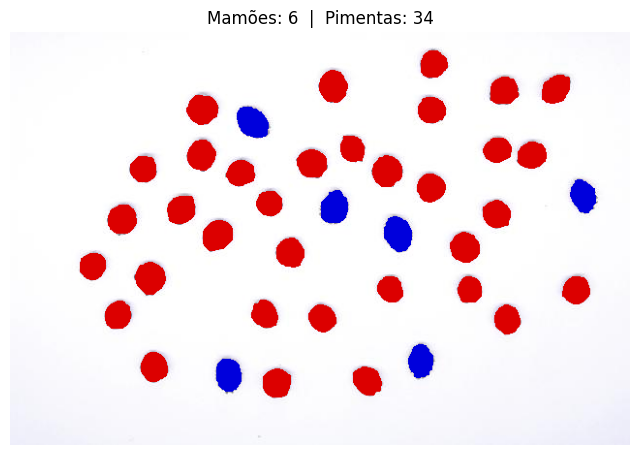

mg_8391: Mamões = 6, Pimentas = 34


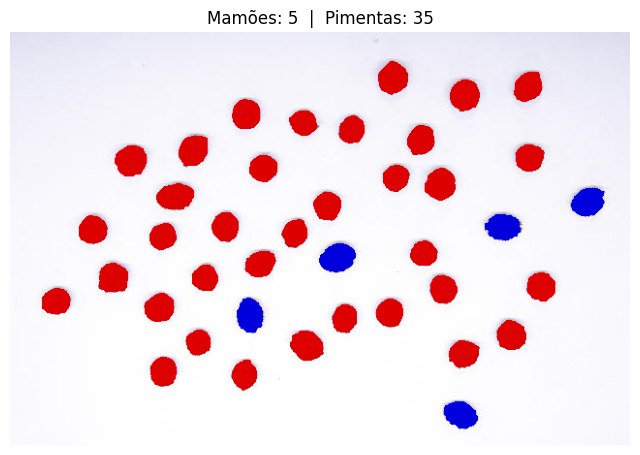

mg_8383: Mamões = 5, Pimentas = 35


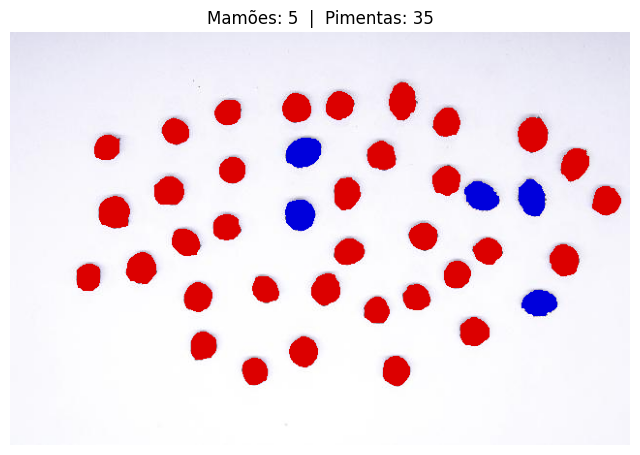

mg_8376: Mamões = 5, Pimentas = 35


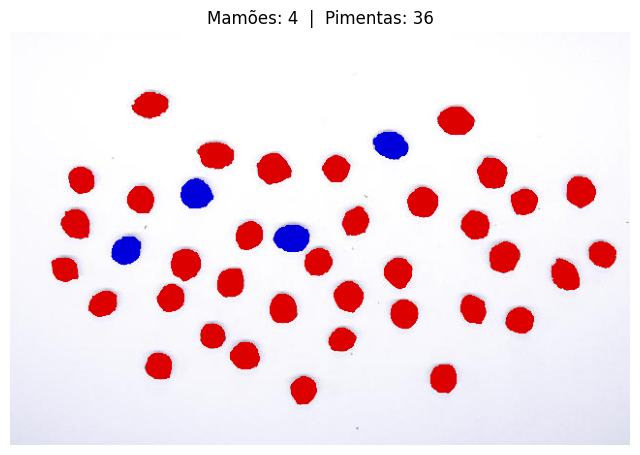

mg_8451: Mamões = 4, Pimentas = 36


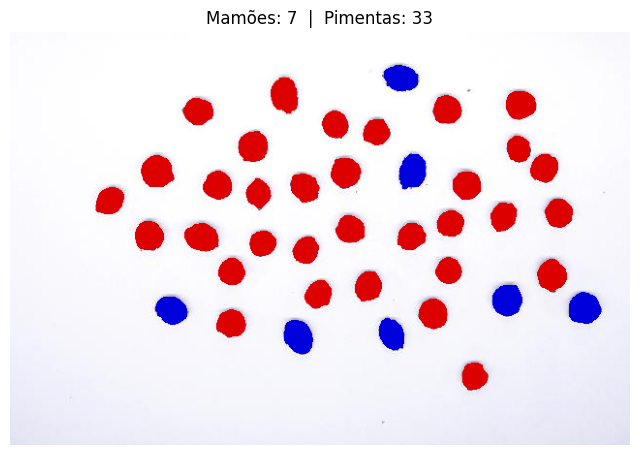

mg_8466: Mamões = 7, Pimentas = 33


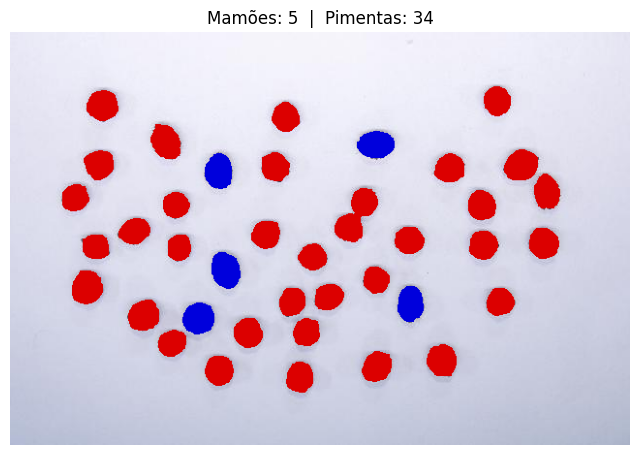

mg_8374: Mamões = 5, Pimentas = 34


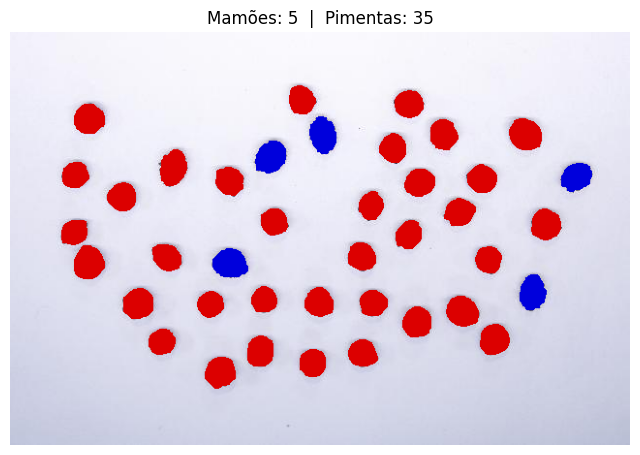

mg_8375: Mamões = 5, Pimentas = 35


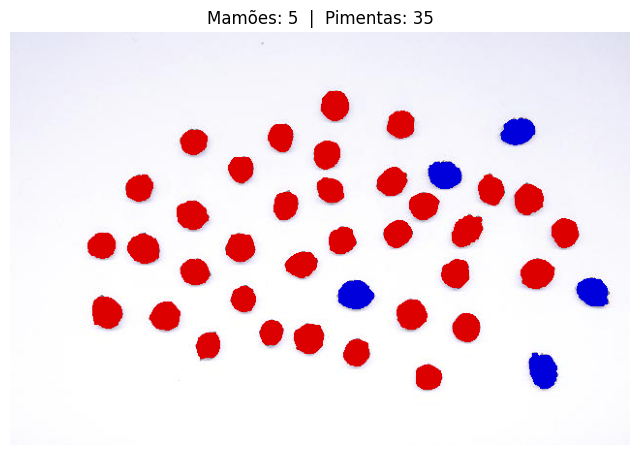

mg_8379: Mamões = 5, Pimentas = 35


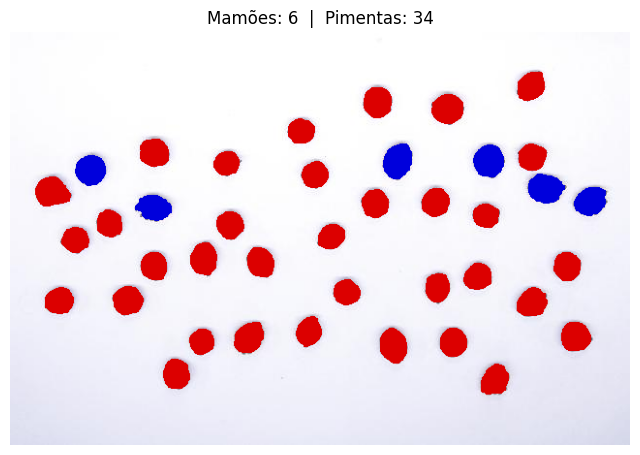

mg_8382: Mamões = 6, Pimentas = 34


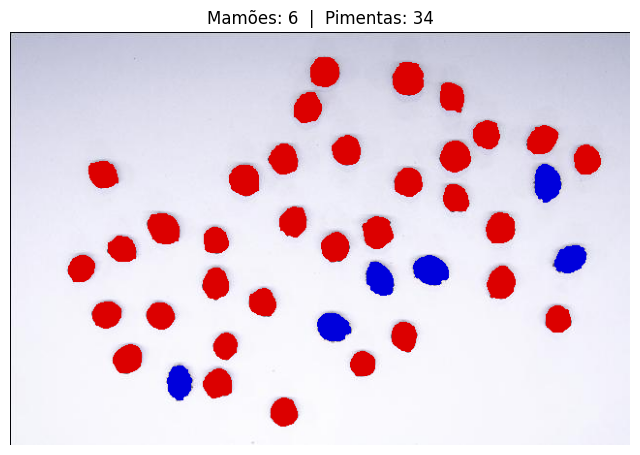

mg_8394: Mamões = 6, Pimentas = 34


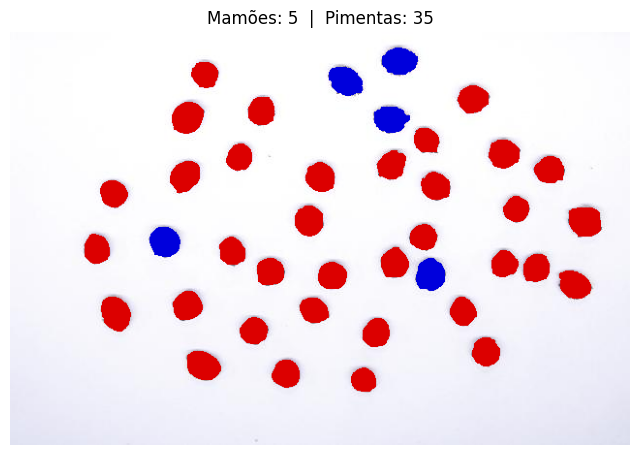

mg_8409: Mamões = 5, Pimentas = 35


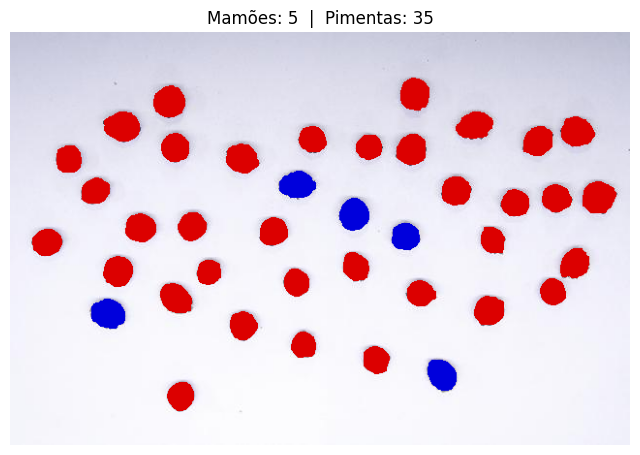

mg_8414: Mamões = 5, Pimentas = 35


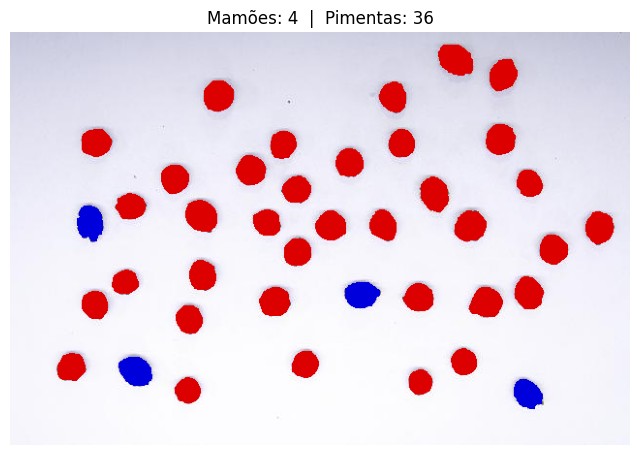

mg_8423: Mamões = 4, Pimentas = 36


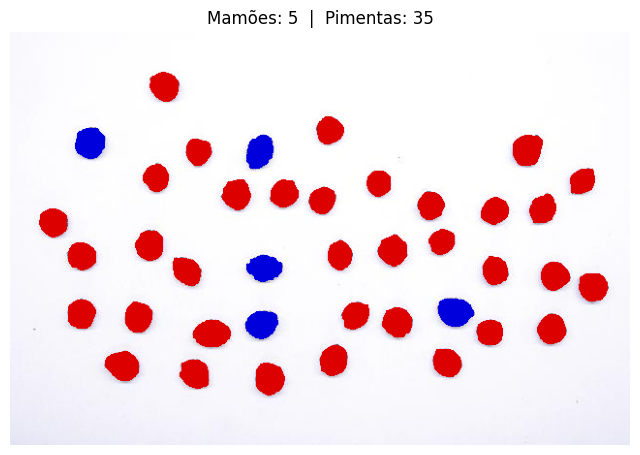

mg_8434: Mamões = 5, Pimentas = 35


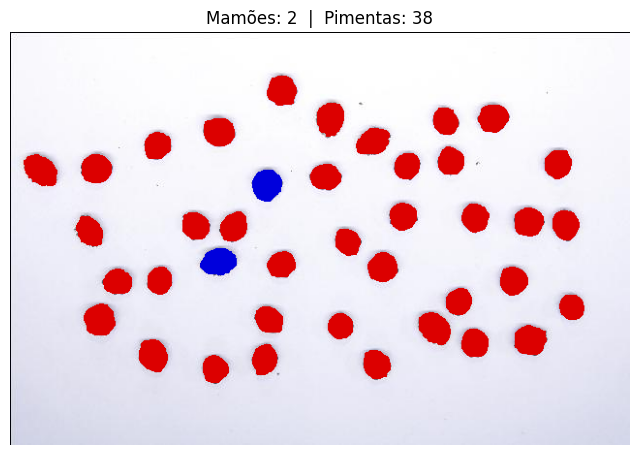

mg_8439: Mamões = 2, Pimentas = 38


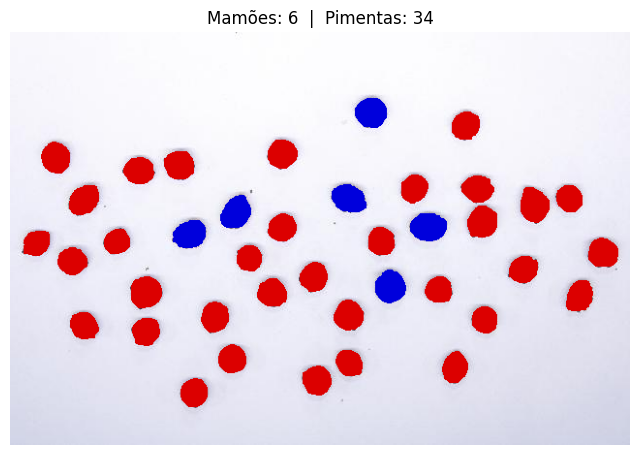

mg_8447: Mamões = 6, Pimentas = 34


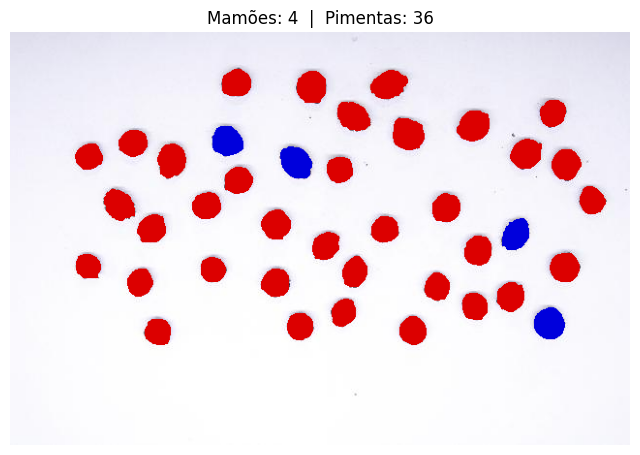

mg_8452: Mamões = 4, Pimentas = 36


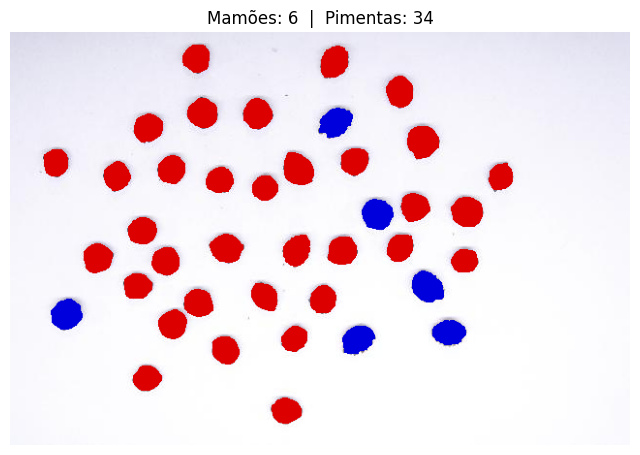

mg_8458: Mamões = 6, Pimentas = 34


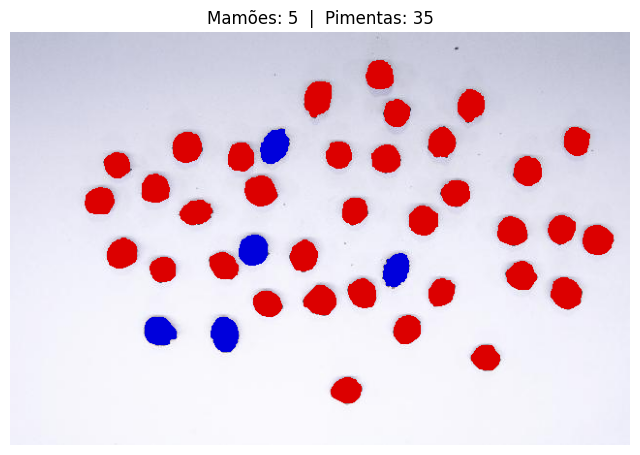

mg_8461: Mamões = 5, Pimentas = 35


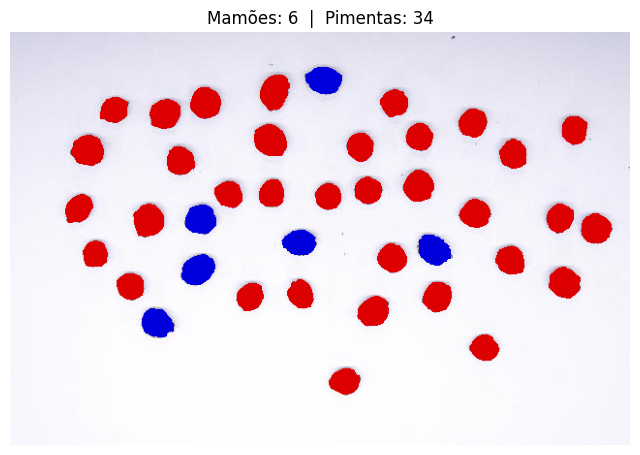

mg_8463: Mamões = 6, Pimentas = 34


In [32]:
for nome, img in [('mg_8391', img1),
                  ('mg_8383', img2),
                  ('mg_8376', img3),
                  ('mg_8451', img4),
                  ('mg_8466', img5),
                  ('mg_8374', img6),
                  ('mg_8375', img7),
                  ('mg_8379', img8),
                  ('mg_8382', img9),
                  ('mg_8394', img10),
                  ('mg_8409', img11),
                  ('mg_8414', img12),
                  ('mg_8423', img13),
                  ('mg_8434', img14),
                  ('mg_8439', img15),
                  ('mg_8447', img16),
                  ('mg_8452', img17),
                  ('mg_8458', img18),
                  ('mg_8461', img19),
                  ('mg_8463', img20)]:
    stats = count_and_classify_fruits(img, top_n=7, show_result=True)
    print(f"{nome}: Mamões = {stats['papaya_count']}, "f"Pimentas = {stats['pepper_count']}")

In [33]:
#------------------Daqui para frente é teste e prototipo de código------------------------------------------------
binary4=segment_light_objects(img_color)


In [34]:
binary3=sobel_edges_threshold_1_15(img_color)


In [35]:
binary5=sobel_edges_threshold_1_5(img_color)


In [36]:
labeled_img, num_components, component_sizes = label_components(binary4)


In [37]:
papaya_indices = select_components_by_overlap(binary4, binary3, binary5, top_n=7)


In [38]:
pepper_indices = [i for i in range(num_components) if i not in papaya_indices]


In [39]:
papaya_indices

[35, 37, 6, 16, 17, 22]

In [40]:
pepper_indices

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 38,
 39]

In [41]:
image_c_new=img_color.copy()


In [42]:
print(binary4.shape)

(426, 640)


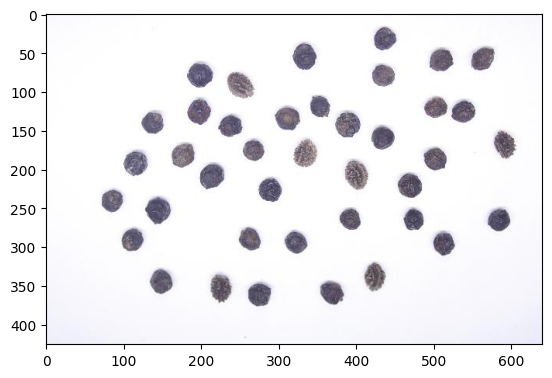

In [43]:
plt.imshow(img1)

In [44]:
mg_8391_grey=color.rgb2gray(img1)

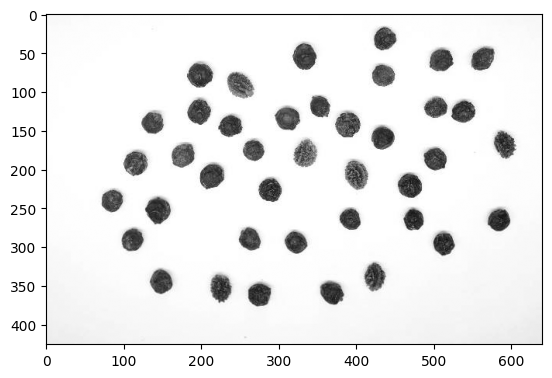

In [45]:
plt.imshow(mg_8391_grey,cmap='grey')

In [46]:
edges=sobel(mg_8391_grey) #extração de bordas

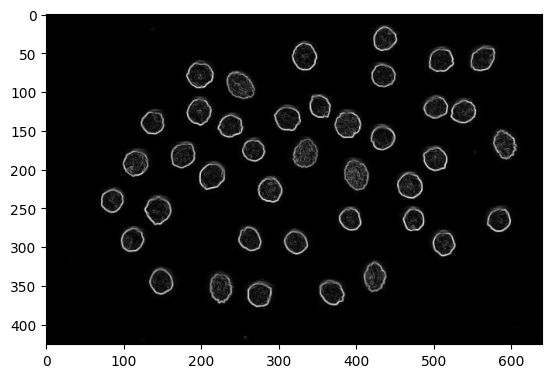

In [47]:
plt.imshow(edges,cmap='grey')

In [48]:
#Criação de uma mascara binaria a partir da borda
binary=edges.copy()
limiar = edges.max()*(1/6)
binary[binary<=limiar]=0
binary[binary>0]=1

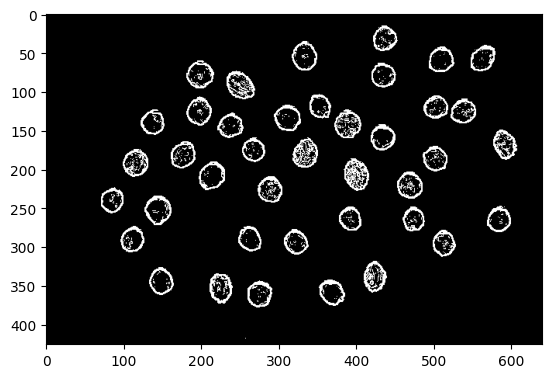

In [49]:

plt.imshow(binary,cmap='grey')

In [50]:
binary = binary_closing (binary)
binary = binary_opening (binary)

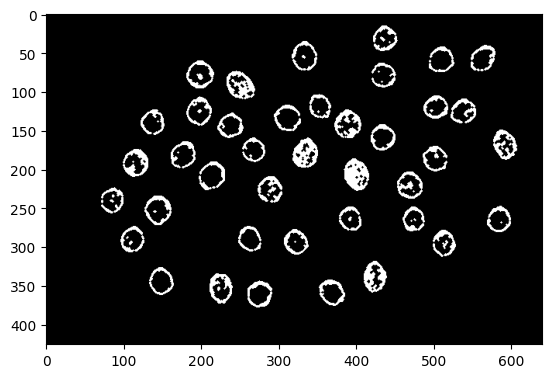

In [51]:
plt.imshow(binary,cmap='grey')

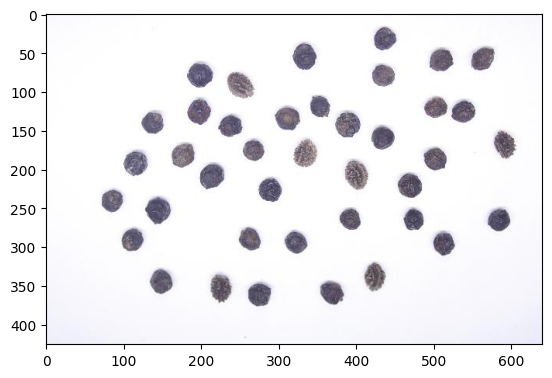

In [52]:
plt.imshow(img1)

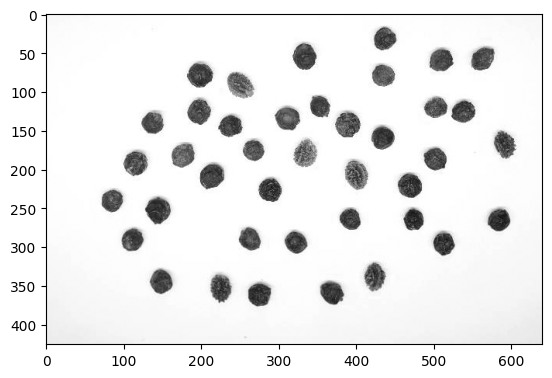

In [53]:
plt.imshow(img1[:,:,0],cmap='grey')

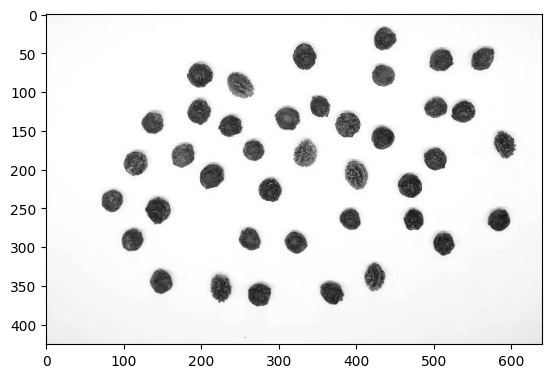

In [54]:
plt.imshow(img1[:,:,1],cmap='grey')

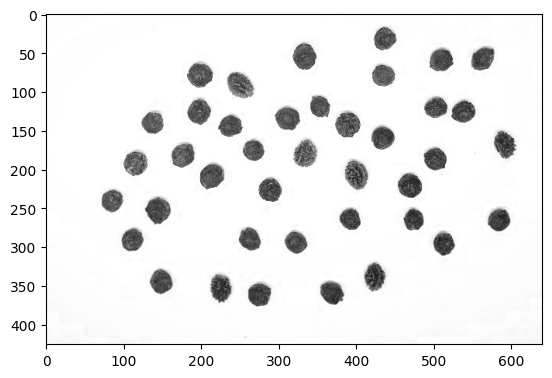

In [55]:
plt.imshow(img1[:,:,2],cmap='grey')

In [56]:
#Nova mascara binaria com limiar dobrado
binary2=edges.copy()
limiar = edges.max()*(1/3)
binary2[binary2<=limiar]=0
binary2[binary2>0]=1

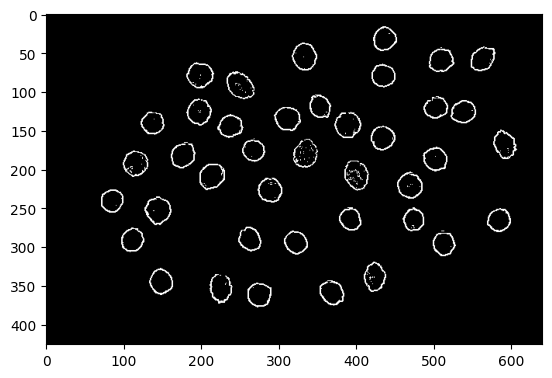

In [57]:
plt.imshow(binary2,cmap='grey')

In [58]:
test=hough_circle(binary2,[15])

In [59]:
acumuladores, a, b, raio = hough_circle_peaks (test, [15],min_xdistance=4,min_ydistance=4)

In [60]:
b

array([222, 160, 228, 362, 193, 127, 345, 209, 188, 183, 135,  61, 146,
        80, 126,  57, 360,  34,  80, 294, 291, 253, 266, 182, 290, 242,
       122, 207, 144, 297, 140, 119, 264,  58,  93, 171, 265, 175])

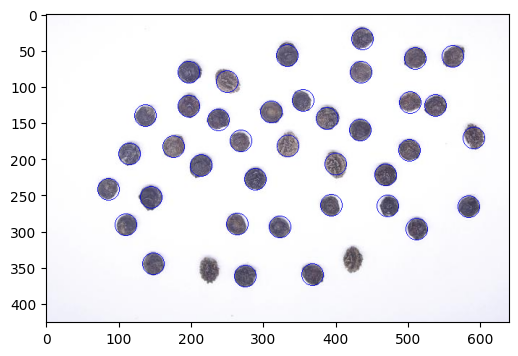

In [61]:
# desenho da figura
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image_color = img1.copy()
for center_y, center_x, radius in zip(b, a, raio):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image_color.shape)
    image_color[circy, circx] = (0, 0, 220)

ax.imshow(image_color, cmap=plt.cm.gray)

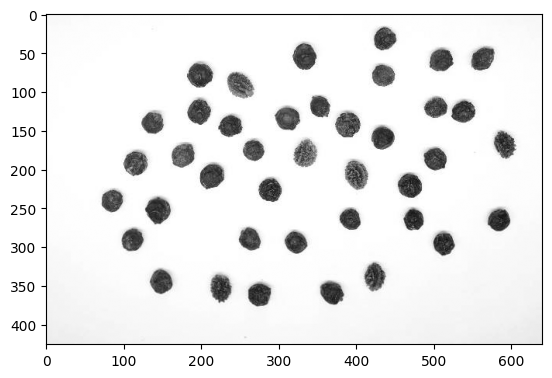

In [62]:
plt.imshow(mg_8391_grey,cmap='grey')

In [63]:
shp=(mg_8391_grey.shape[0]//2,mg_8391_grey.shape[1]//2)
mg_8391_grey_2=np.zeros(shp)
for i in range(shp[0]):
  for j in range(shp[1]):
    mg_8391_grey_2[i,j]=mg_8391_grey[i*2,j*2]

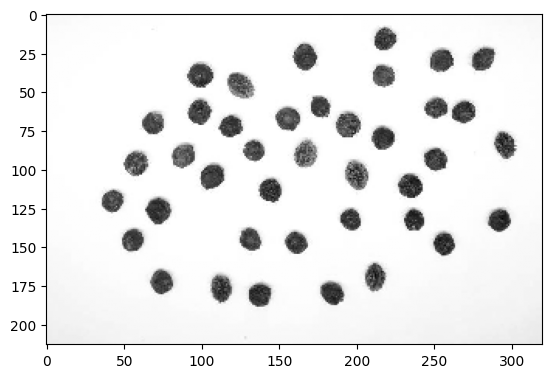

In [64]:
plt.imshow(mg_8391_grey_2,cmap='grey')

In [65]:
edges2=sobel(mg_8391_grey_2)

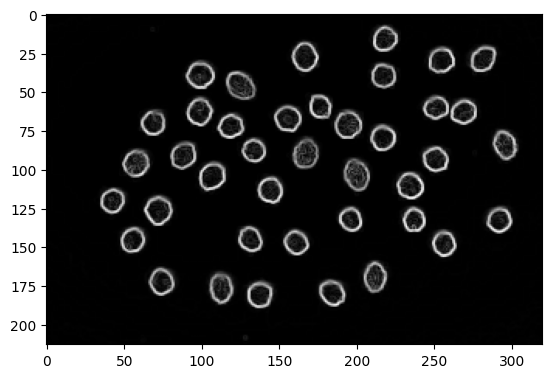

In [66]:
plt.imshow(edges2,cmap='grey')

In [67]:
binary3=edges.copy()
limiar = edges.max()*(1/5)
binary3[binary3<=limiar]=0
binary3[binary3>0]=1
binary3=binary_closing(binary3)
binary3=binary_opening(binary3)

In [68]:
binary5=edges.copy()
limiar = edges.max()*(1/15)
binary5[binary5<=limiar]=0
binary5[binary5>0]=1
binary5=binary_closing(binary5)
binary5=binary_opening(binary5)

In [69]:
binary4=segment_light_objects(img1)

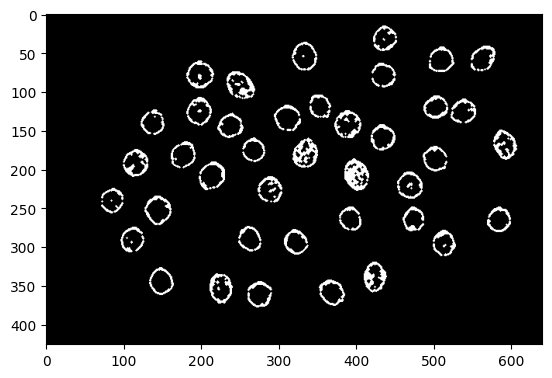

In [70]:
plt.imshow(binary3,cmap='grey')

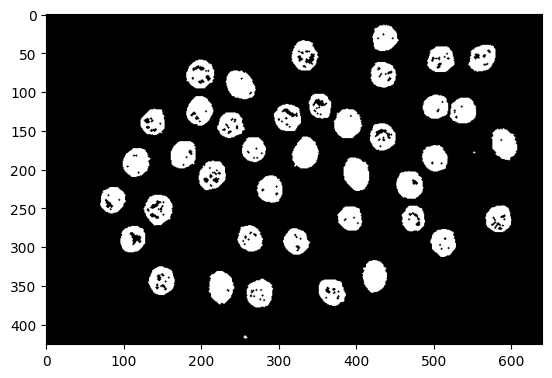

In [71]:
plt.imshow(binary5,cmap='grey')

In [72]:
test = overlap_ratios_per_component(binary4, binary3)

In [73]:
def highlight_components_by_indices(original_image, labeled_image, component_indices_0based,
                                    color=(0, 0, 220), top_n=None):
    # Pinta os componentes especificados em uma cópia da imagem original.
    if top_n is not None:
        indices_to_paint = component_indices_0based[:top_n]
    else:
        indices_to_paint = component_indices_0based.copy()

    # Converter índices 0‑based para rótulos 1‑based
    labels_to_paint = [idx + 1 for idx in indices_to_paint]

    output = original_image.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            label = labeled_image[i, j]
            if label != 0 and label in labels_to_paint:
                output[i, j] = color

    return output

In [74]:
l, c, cl = label_components(binary4)

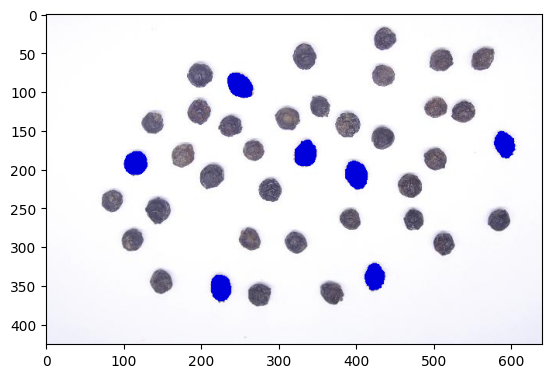

In [75]:
# Obter a imagem rotulada e o número de componentes
labeled_img, num_components, _ = label_components(binary4)

# Calcular as proporções de sobreposição com as bordas de limiar baixo
ratios_low = overlap_ratios_per_component(binary4, binary3)

# Ordenar os índices (0‑based) da maior para a menor proporção
sorted_indices = sorted(range(num_components), key=lambda i: -ratios_low[i])

# Pintar os 7 primeiros componentes na cor azul
image_t = highlight_components_by_indices(
    original_image=img_color,
    labeled_image=labeled_img,
    component_indices_0based=sorted_indices,
    color=(0, 0, 220),
    top_n=7
)

plt.imshow(image_t)

In [76]:
t2 = overlap_ratios_per_component(binary4, binary5)

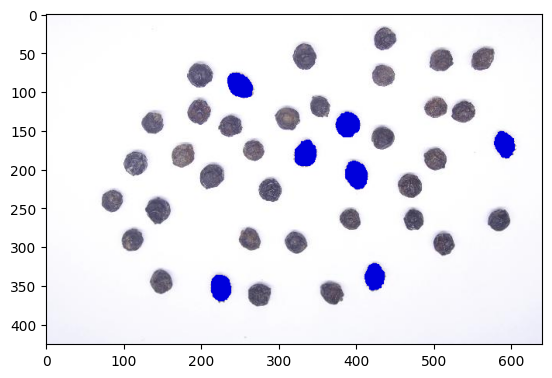

In [77]:
labeled_img, num_components, _ = label_components(binary4)

t2 = overlap_ratios_per_component(binary4, binary5)

sorted_indices_t2 = sorted(range(num_components), key=lambda i: -t2[i])

image_t2 = highlight_components_by_indices(
    original_image=img_color,
    labeled_image=labeled_img,
    component_indices_0based=sorted_indices_t2,
    color=(0, 0, 220),
    top_n=7
)

plt.imshow(image_t2)

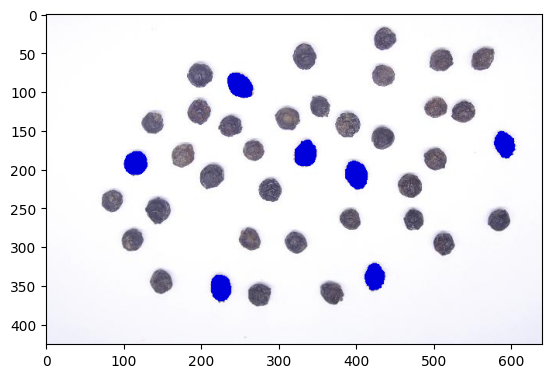

In [78]:
plt.imshow(image_t)

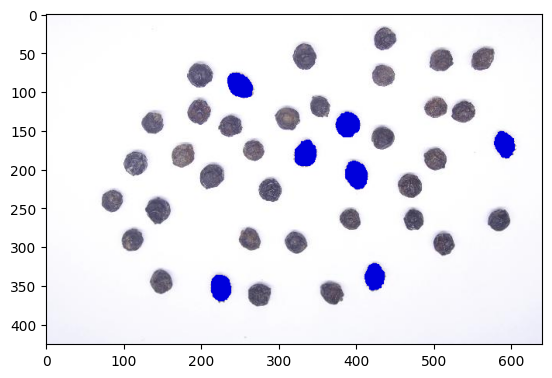

In [79]:
plt.imshow(image_t2)

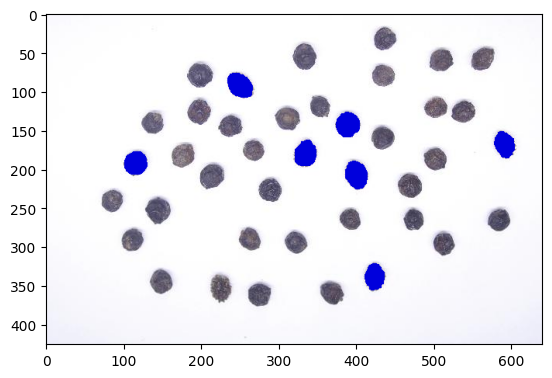

In [80]:
t3 = overlap_counts_per_component(binary4, binary3)

labeled_img, num_components, _ = label_components(binary4)

sorted_indices_t3 = sorted(range(num_components), key=lambda i: -t3[i])

image_t3 = highlight_components_by_indices(
    original_image=img_color,
    labeled_image=labeled_img,
    component_indices_0based=sorted_indices_t3,
    color=(0, 0, 220),
    top_n=7
)

plt.imshow(image_t3)

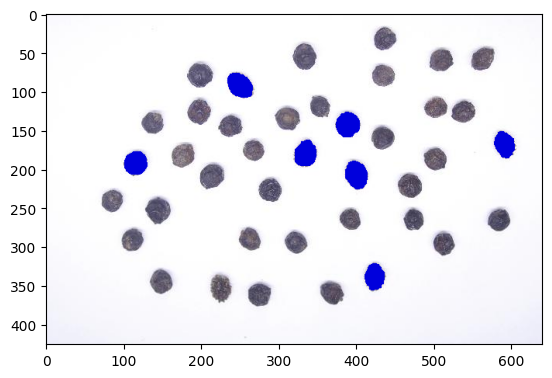

In [81]:
plt.imshow(image_t3)

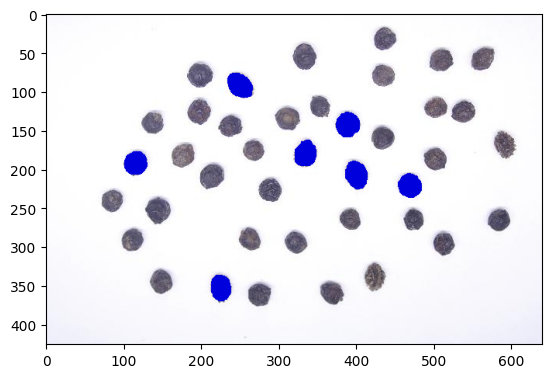

In [82]:
t4 = overlap_counts_per_component(binary4, binary5)

labeled_img, num_components, _ = label_components(binary4)

sorted_indices_t4 = sorted(range(num_components), key=lambda i: -t4[i])

image_t4 = highlight_components_by_indices(
    original_image=img_color,
    labeled_image=labeled_img,
    component_indices_0based=sorted_indices_t4,
    color=(0, 0, 220),
    top_n=7
)

plt.imshow(image_t4)

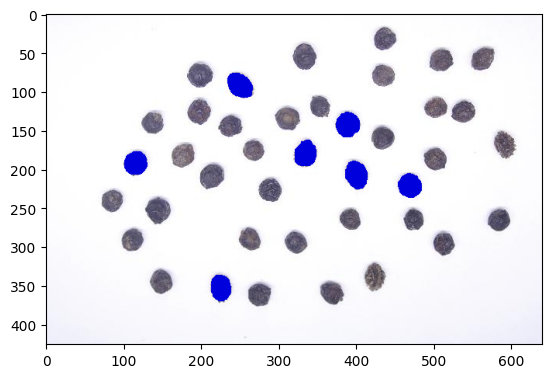

In [83]:
plt.imshow(image_t4)

In [84]:
def highlight_largest_components(binary_mask, original_image, top_n=7, color=(0, 0, 220)):
    # Identifica os `top_n` maiores componentes (por área) em uma máscara binária e os pinta na imagem original com a cor especificada.

    labeled_img, num_components, component_sizes = label_components(binary_mask) # Rotular componentes e obter tamanhos

    if num_components == 0:
        return original_image.copy()

    # Ordenar índices dos componentes (0‑based) por tamanho decrescente
    indices_sorted = sorted(range(num_components), key=lambda i: -component_sizes[i])

    # Selecionar os top_n primeiros
    top_indices = indices_sorted[:top_n]

    # Usar a função de pintura já existente
    output = highlight_components_by_indices(
        original_image=original_image,
        labeled_image=labeled_img,
        component_indices_0based=top_indices,
        color=color,
        top_n=None  # já limitamos a lista
    )
    return output

In [85]:
labeled_img, num_components, component_sizes = label_components(binary5)

In [86]:
num_components

42

In [87]:

def highlight_largest_components_mapped(source_mask, target_mask, original_image,
                                        top_n=7, color=(0, 0, 220)):
    # Identifica os `top_n` maiores componentes (por área) na máscara fonte,
    # mapeia‑os para componentes na máscara alvo e pinta esses componentes alvo
    # sobre a imagem original.


    # Rotular a máscara fonte e obter tamanhos
    labeled_src, num_src, sizes = label_components(source_mask)

    if num_src == 0:
        return original_image.copy()

    #  Obter mapeamento fonte → alvo
    labeled_src, labeled_tgt, mapping = map_labels(source_mask, target_mask)

    # Selecionar índices dos maiores componentes na fonte (0‑based)
    sorted_indices = sorted(range(num_src), key=lambda i: -sizes[i])[:top_n]

    # Mapear para índices no alvo, ignorando os que não têm correspondência
    target_indices = [mapping[i] for i in sorted_indices if mapping[i] != -1]

    # Pintar os componentes correspondentes na imagem original
    output = highlight_components_by_indices(
        original_image=original_image,
        labeled_image=labeled_tgt,
        component_indices_0based=target_indices,
        color=color,
        top_n=None  # a lista já está limitada
    )
    return output

In [88]:
def map_labels(source_mask, target_mask):

    # Cria um mapeamento de componentes da máscara fonte para a máscara alvo.
    # Para cada componente na fonte, encontra o primeiro pixel sobreposto no alvo
    # e registra o rótulo correspondente (0‑based). Se não houver sobreposição, o valor é -1.


    labeled_src, num_src, _ = label_components(source_mask)
    labeled_tgt, _, _ = label_components(target_mask)

    mapping = [-1] * num_src
    for i in range(source_mask.shape[0]):
        for j in range(source_mask.shape[1]):
            src_label = labeled_src[i, j]
            if src_label != 0 and mapping[src_label - 1] == -1:
                tgt_label = labeled_tgt[i, j]
                if tgt_label != 0:
                    mapping[src_label - 1] = tgt_label - 1  # 0‑based
    return labeled_src, labeled_tgt, mapping

In [89]:
img=binary5.copy()
img2=binary4.copy()

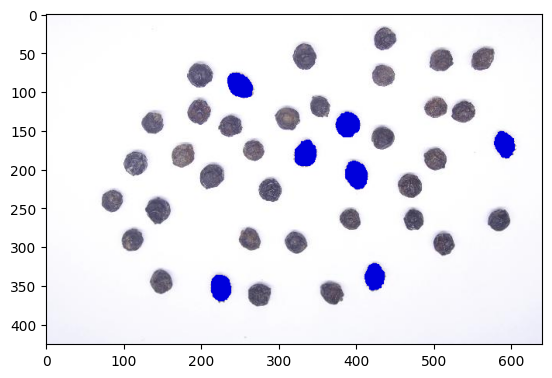

In [90]:
plt.imshow(highlight_largest_components_mapped(binary5,binary4,img_color))

In [91]:
labeled_img, num_components, component_sizes = label_components(binary3)

In [92]:
test_label=list(range(num_components))

In [93]:
test_label.sort(key=lambda n:-component_sizes[n])

In [94]:
best_label=test_label[0:7]
best_label=[i+1 for i in best_label]

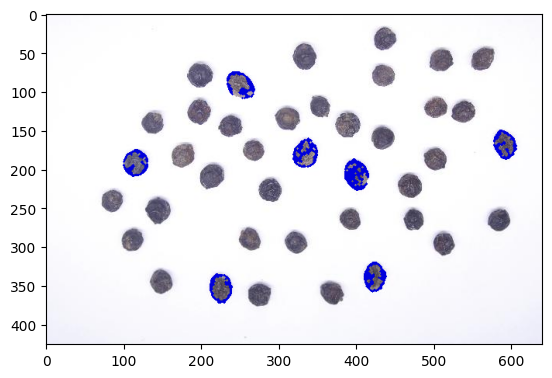

In [95]:
# Converter best_label (rótulos 1‑based) para índices 0‑based
indices_0based = [label - 1 for label in best_label]

# Converter índices 0‑based para rótulos 1‑based (formato usado na imagem rotulada)
best_label = [idx + 1 for idx in indices_0based]

# Copiar a imagem original e pintar os componentes
image_c_new = img1.copy()
for i in range(image_c_new.shape[0]):
    for j in range(image_c_new.shape[1]):
        if labeled_img[i, j] in best_label:
            image_c_new[i, j] = (0, 0, 220)

plt.imshow(image_c_new)

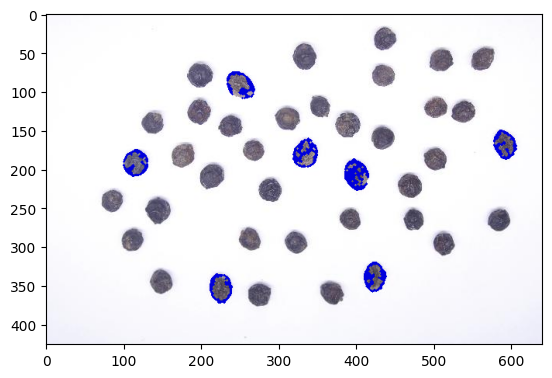

In [96]:
plt.imshow(image_c_new)

In [97]:
labeled2, current_label2, counts_label2 = label_components(binary)

In [98]:
test_label2=list(range(42))
test_label2.sort(key=lambda n:-counts_label2[n])
best_label2=test_label2[0:6]
best_label2=[i+1 for i in best_label2]

In [99]:
image_c_new2=img1.copy()
for i in range(image_c_new2.shape[0]):
  for j in range(image_c_new2.shape[1]):
    if labeled2[i,j] in best_label2:
      image_c_new2[i,j]=(0,0,220)

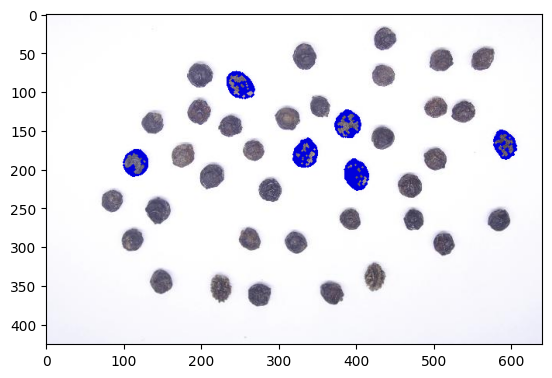

In [100]:
plt.imshow(image_c_new2)

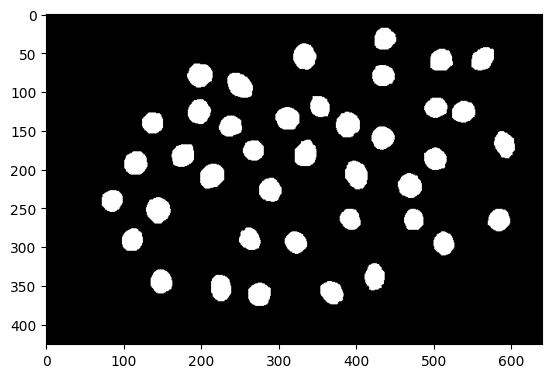

In [101]:
plt.imshow(binary4,cmap='grey')

In [102]:
labeled3,current_label3, counts_label3=label_components(binary4)

In [103]:
total_lum_label3=[0 for i in range(current_label3)]

In [104]:
for i in range(binary4.shape[0]):
  for j in range(binary4.shape[1]):
    label=labeled3[i,j]
    if label!=0:
      total_lum_label3[label-1]+=mg_8391_grey[i,j]

In [105]:
avg_lum_label3=[total_lum_label3[i]/counts_label3[i] for i in range(current_label3)]

In [106]:
labels3=list(range(current_label3))

In [107]:
filtered_labels3=[i for i in labels3 if counts_label3[i] > max(counts_label3)/8]

In [108]:
#new_avg_label_3=[avg_lum_label3[i] for i in range(current_label3) if i in filtered_labels3]

In [109]:
sorted_filtered_labels3=sorted(filtered_labels3,key=lambda i: -avg_lum_label3[i])

In [110]:
best_labels3=sorted_filtered_labels3[0:6]

In [111]:
best_labels3=[i+1 for i in best_labels3]

In [112]:
[counts_label3[i] for i in best_labels3]

[569, 563, 800, 666, 822, 829]

In [113]:
avg_lum_label3[19]

np.float64(0.48114322303921636)

In [114]:
image_c_new_3=img1.copy()
for i in range(image_c_new_3.shape[0]):
  for j in range(image_c_new_3.shape[1]):
    if labeled3[i,j] in best_labels3:
      image_c_new_3[i,j]=(0,0,220)

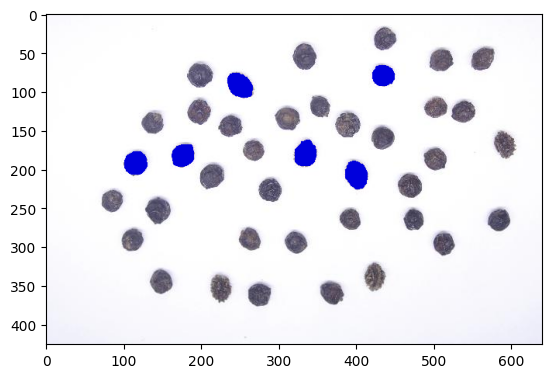

In [115]:
plt.imshow(image_c_new_3)

In [116]:
labeled4,current_label4, counts_label4=label_components(binary4)

In [117]:
labels_4=list(range(current_label4))

In [118]:
filtered_labels4=[i for i in labels_4 if counts_label4[i]>max(counts_label4)/8]

In [119]:
xys_labels_4=[[] for i in range(current_label4)]

In [120]:
def extract_label(img,label,count):
  xys_labels=[[] for i in range(count)]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j]-1 in label:
        xys_labels[img[i,j]-1].append((i,j))
  return xys_labels

In [121]:
for i in range(binary4.shape[0]):
  for j in range(binary4.shape[1]):
    if labeled4[i,j]-1 in filtered_labels4:
      xys_labels_4[labeled4[i,j]-1].append((i,j))

In [122]:
def rot(point,angle):
  return (point[0]*math.cos(angle)-point[1]*math.sin(angle),point[1]*math.cos(angle)+point[0]*math.sin(angle))

In [123]:
def rotate(ls,angle):
  return [rot(point,angle) for point in ls]

In [124]:
def rotatebig(big_ls,angle):
  return [rotate(ls,angle) for ls in big_ls]

In [125]:
def biggerls(big_ls,n):
  return [rotatebig(big_ls,i*math.pi/(2*n)) for i in range(n)]

In [126]:
xys_labels_4_quarto=[rotate(ls,math.pi/8) for ls in xys_labels_4]

In [127]:
xys_labels_4_meio=[rotate(ls,math.pi/4) for ls in xys_labels_4]

In [128]:
xys_labels_4_3quartos=[rotate(ls,3*math.pi/8) for ls in xys_labels_4]

In [129]:
def ls_mag(ls):
  if(ls==[]): return 0
  xls=[p[0] for p in ls]
  yls=[p[1] for p in ls]
  x=max(xls)-min(xls)
  y=max(yls)-min(yls)
  return math.sqrt(x**2+y**2)

In [130]:
def big_ls_mag(big_ls):
  return [ls_mag(ls) for ls in big_ls]

In [131]:
def bigger_ls_mag(bigger_ls):
  n=len(bigger_ls[0])
  zipped=[[] for i in range(n)]
  for j in range(n):
    for i in range(len(bigger_ls)):
      zipped[j].append(bigger_ls[i][j])
  max_mags=[0 for i in range(n)]
  for i in range(n):
    mags=[ls_mag(ls) for ls in zipped[i]]
    max_mags[i]=max(mags)
  return max_mags

In [132]:
max_mags_4=bigger_ls_mag(biggerls(xys_labels_4,16))

In [133]:
#max_mags_4=[max(ls_mag(xys_labels_4[i]),ls_mag(xys_labels_4_quarto[i]),ls_mag(xys_labels_4_meio[i]),ls_mag(xys_labels_4_3quartos[i])) for i in range(current_label4)]

In [134]:
sorted_labels_4=sorted(filtered_labels4,key=lambda i:-max_mags_4[i]/(counts_label4[i]**(1/2)))

In [135]:
best_labels4=sorted_labels_4[0:6]
best_labels4=[i+1 for i in best_labels4]

In [136]:
image_c_new_4=img1.copy()
for i in range(image_c_new_4.shape[0]):
  for j in range(image_c_new_4.shape[1]):
    if labeled4[i,j] in best_labels4:
      image_c_new_4[i,j]=(0,0,220)

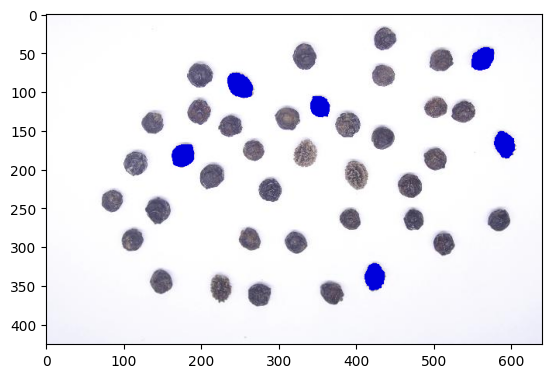

In [137]:
plt.imshow(image_c_new_4)

In [138]:
def extract_boundary_from_points(points):

    # Extrai os pixels de borda de um componente a partir de uma lista de coordenadas.

    if not points:
        return []

    # Extrair coordenadas
    rows = [p[0] for p in points]
    cols = [p[1] for p in points]

    min_row = min(rows)
    max_row = max(rows)
    min_col = min(cols)
    max_col = max(cols)

    # Criar uma imagem pequena apenas para este componente
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    component_image = np.zeros((height, width), dtype=np.uint8)

    # Preencher a imagem com os pixels do componente
    for r, c in points:
        component_image[r - min_row, c - min_col] = 1

    # Encontrar a borda (4‑conectividade)
    boundary = []
    for i in range(height):
        for j in range(width):
            if component_image[i, j] == 0:
                continue

            # Pixel na borda da imagem local?
            if i == 0 or j == 0 or i == height - 1 or j == width - 1:
                boundary.append((min_row + i, min_col + j))
                continue

            # Verifica se algum vizinho 4‑conectado é fundo
            if (component_image[i-1, j] == 0 or
                component_image[i+1, j] == 0 or
                component_image[i, j-1] == 0 or
                component_image[i, j+1] == 0):
                boundary.append((min_row + i, min_col + j))

    return boundary

Text(0.5, 1.0, 'Borda do componente 2')

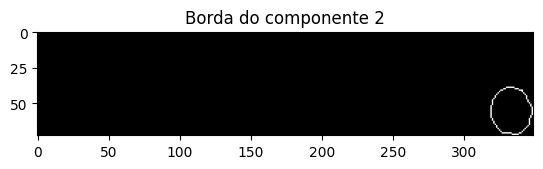

In [139]:
# Supondo que xys_labels_4 seja a lista de pontos dos componentes filtrados
component_index = 1  # segundo componente
component_points = xys_labels_4[component_index]

# Extrair borda
boundary_points = extract_boundary_from_points(component_points)

# Criar imagem para visualização (opcional)
max_row = max(p[0] for p in boundary_points)
max_col = max(p[1] for p in boundary_points)
boundary_image = np.zeros((max_row + 1, max_col + 1))
for r, c in boundary_points:
    boundary_image[r, c] = 1

plt.imshow(boundary_image, cmap='gray')
plt.title(f'Borda do componente {component_index + 1}')

In [140]:
len(counts_label4)

40

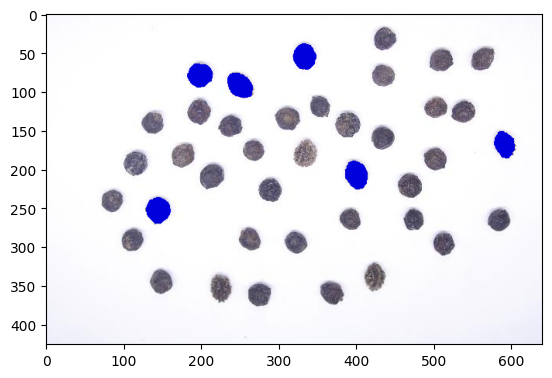

In [141]:
labeled4, current_label4, counts_label4 = label_components(binary4)

# Calcular o coeficiente (boundary_size / counts_label4^(1/4))
new_image, boundary_size = extract_boundary(labeled4, current_label4)
coef = [boundary_size[i] / (counts_label4[i] ** (1/4)) for i in range(current_label4)]

# Ordenar e pegar os 6 melhores
labels_5 = list(range(current_label4))
sorted_labels_5 = sorted(labels_5, key=lambda i: -coef[i])
best_labels5 = sorted_labels_5[0:6]
best_labels5 = [i+1 for i in best_labels5]   # converte para rótulos 1‑based

# Agora sim, pintar
image_c_new_5 = img1.copy()
for i in range(image_c_new_5.shape[0]):
    for j in range(image_c_new_5.shape[1]):
        if labeled4[i, j] in best_labels5:
            image_c_new_5[i, j] = (0, 0, 220)
plt.imshow(image_c_new_5)

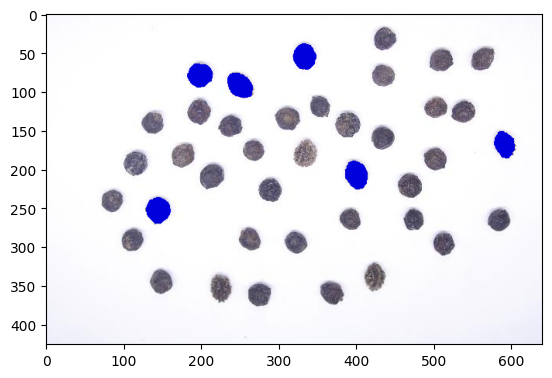

In [142]:
plt.imshow(image_c_new_5)